In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("="*70)
print("   SMURF HEART FAILURE PROJECT: PART 2 - NONLINEAR MODELS")
print("="*70)

   SMURF HEART FAILURE PROJECT: PART 2 - NONLINEAR MODELS



[STEP 1] Loading data and preprocessor...
Training data shape: (1000, 18)
Target variable shape: (1000,)

[STEP 2] Analyzing feature importance...
Total features after preprocessing: 18

  Method 1: F-statistic (correlation-based)

Top 10 features by F-score:
                                     Feature     F_Score
1                             blood pressure  765.187456
3                                cholesterol  251.986169
8                                     weight  211.753990
11                              smurfin_dots  109.499163
12  profession_administration and governance   60.449747
0                                        age   51.110103
9                               sarsaparilla   41.607918
14                profession_food production   27.723959
4                                 hemoglobin   26.540494
17                       profession_services   20.069050

  Method 2: Mutual Information

Top 10 features by Mutual Information:
                                     Fea

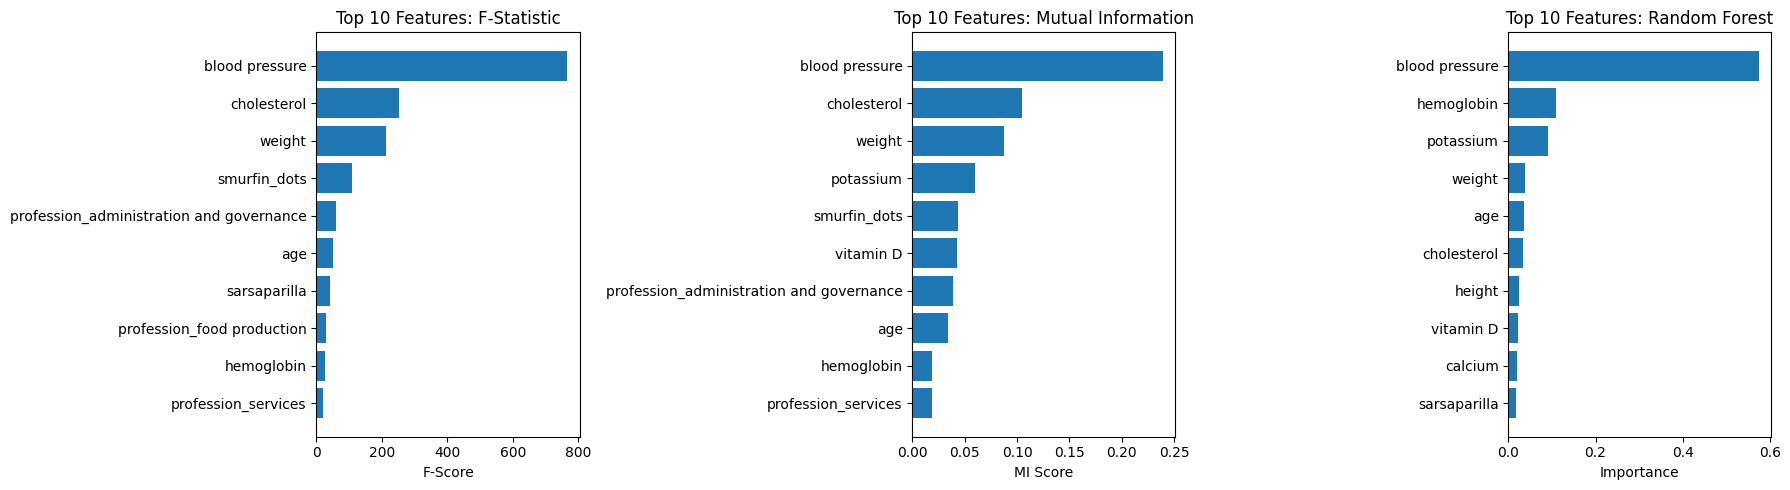

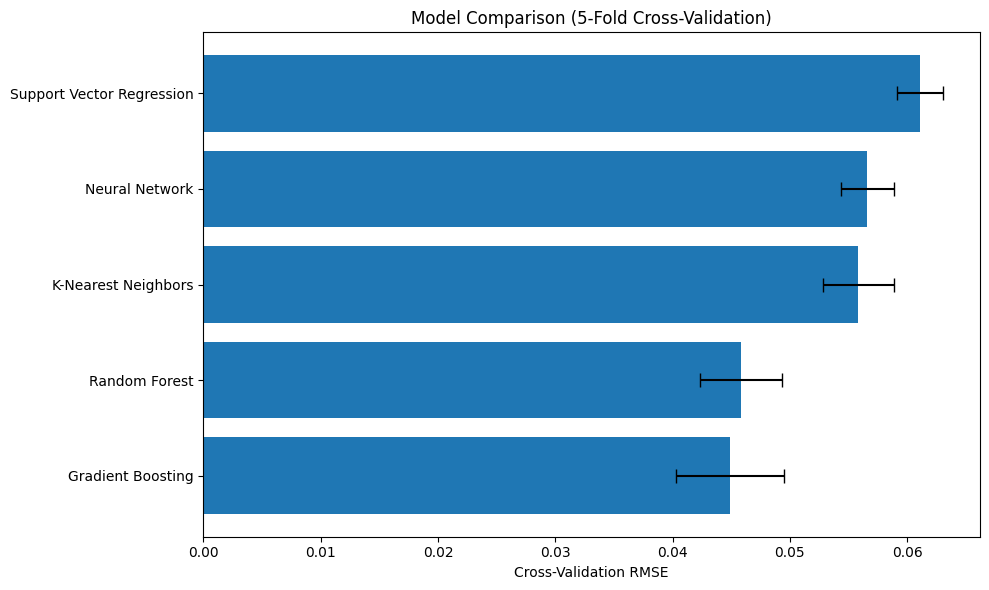

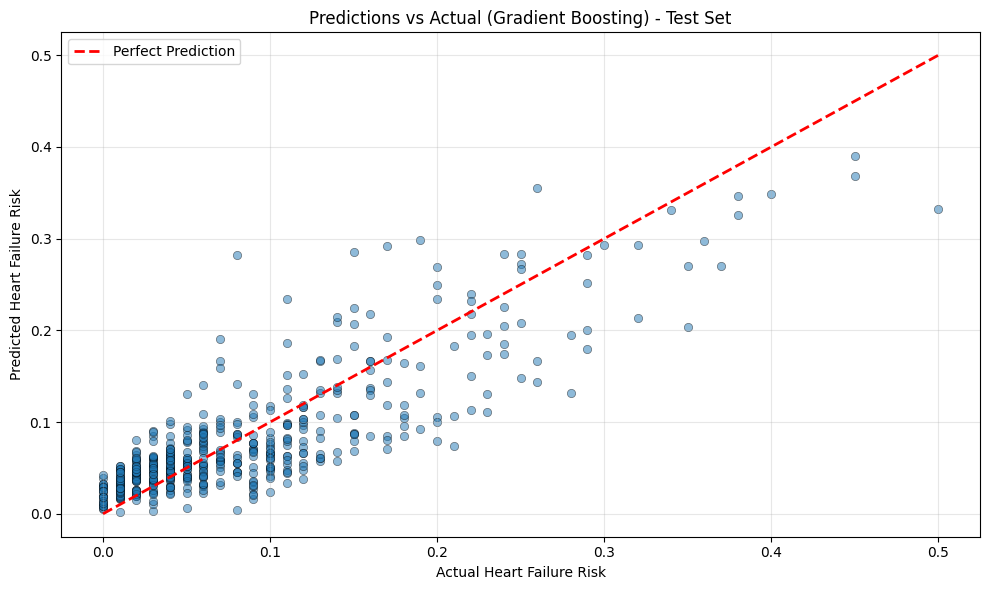

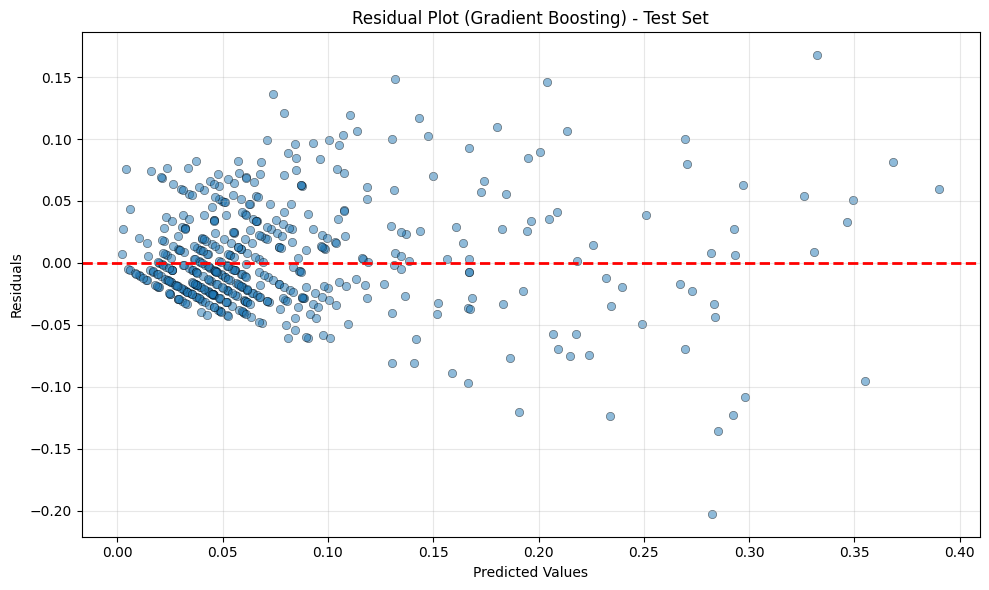

In [16]:

# ============================================================================
# STEP 1: LOAD DATA AND PREPROCESSOR
# ============================================================================
print("\n[STEP 1] Loading data and preprocessor...")
# Load the preprocessor from Part 1
preprocessor = joblib.load('smurf_preprocessor.joblib')

# Load training data
df_X_train = pd.read_csv("X_train.csv")

df_y_train = pd.read_csv("y_train.csv", header=None, names=['heart_failure_risk'])

y_train = df_y_train['heart_failure_risk'].values

# Apply same column renaming as Part 1
df_X_train_renamed = df_X_train.rename(columns={
    'smurfberry liquor': 'smurfberry_liquor',
    'smurfin donuts': 'smurfin_dots'
})
# Transform training data using fitted preprocessor

X_train_processed = preprocessor.transform(df_X_train_renamed)

print(f"Training data shape: {X_train_processed.shape}")

print(f"Target variable shape: {y_train.shape}")

# Numerical feature names

numerical_features = ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 

                      'height', 'potassium', 'vitamin D', 'weight']

processed_feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
    preprocessor.named_transformers_['ord'].get_feature_names_out().tolist() +
    preprocessor.named_transformers_['nom'].get_feature_names_out().tolist()
)
X_train_standardized = X_train_processed.copy()

scX = StandardScaler()

X_train_standardized[:, numerical_indices] = scX.fit_transform(
    X_train_processed[:, numerical_indices]
)

X_train_processed = X_train_standardized


print("\n[STEP 2] Analyzing feature importance...")

feature_names = (
    preprocessor.named_transformers_['num'].get_feature_names_out().tolist() +
    preprocessor.named_transformers_['ord'].get_feature_names_out().tolist() +
    preprocessor.named_transformers_['nom'].get_feature_names_out().tolist()
)

print(f"Total features after preprocessing: {len(feature_names)}")

# 1: Correlation-based (F-statistic)
print("\n  Method 1: F-statistic (correlation-based)")
selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X_train_processed, y_train)
f_scores = pd.DataFrame({
    'Feature': feature_names,
    'F_Score': selector_f.scores_
}).sort_values('F_Score', ascending=False)

print("\nTop 10 features by F-score:")
print(f_scores.head(10))

#2: Mutual Information (using it to capture NL relationships)
print("\n  Method 2: Mutual Information")
mi_scores = mutual_info_regression(X_train_processed, y_train, random_state=42)
mi_df = pd.DataFrame({
    'Feature': feature_names,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 10 features by Mutual Information:")
print(mi_df.head(10))

#3: Random Forest Feature Importance
print("\n  Method 3: Random Forest Feature Importance")
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_train_processed, y_train)
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_temp.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features by Random Forest:")
print(rf_importance.head(10))

# Save feature importance analysis
feature_analysis = {
    'f_scores': f_scores,
    'mi_scores': mi_df,
    'rf_importance': rf_importance
}
joblib.dump(feature_analysis, 'feature_importance_analysis.joblib')

# ============================================================================
# STEP 3: FEATURE SELECTION
# ============================================================================
print("\n[STEP 3] Performing feature selection...")

#  trying different numbers of features
n_features_to_try = [10, 15, 20, 'all']

K_FEATURES = 15  # You can adjust this
print(f"\nSelecting top {K_FEATURES} features based on Mutual Information...")

selector_mi = SelectKBest(score_func=mutual_info_regression, k=K_FEATURES)
X_train_selected = selector_mi.fit_transform(X_train_processed, y_train)

selected_features = [feature_names[i] for i in selector_mi.get_support(indices=True)]
print(f"\nSelected features ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i}. {feat}")

print("\n[STEP 4] Comparing multiple nonlinear models...")
print("Using 5-fold cross-validation on training data...")

models = {
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'Neural Network': MLPRegressor(activation='logistic',random_state=42, max_iter=2000)
}

cv_results = {}

print("\nRunning cross-validation for each model...")
print("-" * 70)

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    cv_scores = cross_val_score(
        model, X_train_selected, y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    rmse_scores = np.sqrt(-cv_scores)
    
    cv_results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std(),
        'scores': rmse_scores
    }
    
    print(f"  Cross-Val RMSE: {rmse_scores.mean():.6f} (+/- {rmse_scores.std():.6f})")

print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS SUMMARY (on Training Data)")
print("="*70)
results_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean CV RMSE': [cv_results[m]['mean_rmse'] for m in cv_results.keys()],
    'Std CV RMSE': [cv_results[m]['std_rmse'] for m in cv_results.keys()]
}).sort_values('Mean CV RMSE')

print(results_df.to_string(index=False))

print("\n[STEP 5] Deep Hyperparameter Tuning for top 2 models (Random Forest, Gradient Boosting)...")

# Selecting  top 2 models for deep tuning -> cause the both models gave good rsults consistently.
top_2_models = results_df.head(2)['Model'].tolist()

# Define models and use GridSearchCV (full search) for the top model
tuned_models = {}


param_grid_rf_dense = {
    'n_estimators': [250, 350, 450], # More trees for better averaging
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': [0.8, 1.0]
}


param_grid_gb_dense = {
    'n_estimators': [250,350],
    'learning_rate': [0.03, 0.05],
    'max_depth': [2, 3],
    'subsample': [0.75, 0.8]
}

tuning_configs = {
    'Random Forest': (RandomForestRegressor(random_state=42, n_jobs=-1), param_grid_rf_dense, GridSearchCV),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), param_grid_gb_dense, GridSearchCV),
}


for model_name in top_2_models:
    if model_name in tuning_configs:
        model, param_grid, search_method = tuning_configs[model_name]
        
        print(f"\n  Tuning {model_name} with {search_method.__name__} (EXHAUSTIVE SEARCH)...")
        
        search = search_method(
            model,
            param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1, # Maximize speed
            verbose=1
        )
        
        search.fit(X_train_selected, y_train)
        tuned_models[model_name] = {
            'model': search.best_estimator_,
            'best_params': search.best_params_,
            'best_rmse': np.sqrt(-search.best_score_)
        }
        print(f"    Best CV RMSE: {tuned_models[model_name]['best_rmse']:.6f}")
        print(f"    Best parameters: {search.best_params_}")

print("\n[STEP 6] Selecting the Absolute Best Model...")

best_model_name = min(tuned_models.keys(), 
                      key=lambda x: tuned_models[x]['best_rmse'])
best_model = tuned_models[best_model_name]['model']

print(f"\n*** ABSOLUTE BEST MODEL: {best_model_name} ***")
print(f"BEST CV RMSE: {tuned_models[best_model_name]['best_rmse']:.6f}")
print(f"Best parameters: {tuned_models[best_model_name]['best_params']}")

print("\nTraining best model on full training set...")
best_model.fit(X_train_selected, y_train)

y_train_pred = best_model.predict(X_train_selected)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print(f"\nTraining Set Performance:")
print(f"  RMSE: {train_rmse:.6f}")
print(f"  R²:   {train_r2:.6f}")
print(f"  MAE:  {train_mae:.6f}")

print("\n[STEP 7] Final evaluation on test set...")

df_X_test = pd.read_csv("X_test.csv")
df_y_test = pd.read_csv("y_test.csv", header=None, 
                        names=['heart_failure_risk'])
y_test = df_y_test['heart_failure_risk'].values

df_X_test_renamed = df_X_test.rename(columns={
    'smurfberry liquor': 'smurfberry_liquor',
    'smurfin donuts': 'smurfin_dots'
})


X_test_processed = preprocessor.transform(df_X_test_renamed)

X_test_standardized = X_test_processed.copy()
X_test_standardized[:, numerical_indices] = scX.transform(
    X_test_processed[:, numerical_indices]
)


X_test_selected = selector_mi.transform(X_test_standardized)

y_test_pred = best_model.predict(X_test_selected)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n" + "="*70)
print("           FINAL TEST SET PERFORMANCE")
print("="*70)
print(f"Model: {best_model_name}")
print(f"\nTest Set Metrics:")
print(f"  RMSE: {test_rmse:.6f}")
print(f"  R²:   {test_r2:.6f}")
print(f"  MAE:  {test_mae:.6f}")
print("="*70)

# STEP 8
print("\n[STEP 8] Saving results and models...")
joblib.dump(selector_mi, 'feature_selector.joblib')
joblib.dump(best_model, 'best_nonlinear_model.joblib')

results_summary = {
    'best_model_name': best_model_name,
    'best_params': tuned_models[best_model_name]['best_params'],
    'selected_features': selected_features,
    'cv_rmse': tuned_models[best_model_name]['best_rmse'],
    'train_rmse': train_rmse,
    'train_r2': train_r2,
    'train_mae': train_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2,
    'test_mae': test_mae,
    'all_cv_results': cv_results,
    'tuned_models': {k: {'params': v['best_params'], 'rmse': v['best_rmse']} 
                     for k, v in tuned_models.items()}
}

joblib.dump(results_summary, 'part2_results_summary.joblib')

print("\nSaved files:")
print("  - feature_selector.joblib")
print("  - best_nonlinear_model.joblib")
print("  - part2_results_summary.joblib")
print("  - feature_importance_analysis.joblib")

# STEP 9
print("\n[STEP 9] Generating visualizations...")

# 1. Feature importance comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F-score
axes[0].barh(f_scores.head(10)['Feature'], f_scores.head(10)['F_Score'])
axes[0].set_xlabel('F-Score')
axes[0].set_title('Top 10 Features: F-Statistic')
axes[0].invert_yaxis()

# Mutual Information
axes[1].barh(mi_df.head(10)['Feature'], mi_df.head(10)['MI_Score'])
axes[1].set_xlabel('MI Score')
axes[1].set_title('Top 10 Features: Mutual Information')
axes[1].invert_yaxis()

# Random Forest
axes[2].barh(rf_importance.head(10)['Feature'], rf_importance.head(10)['Importance'])
axes[2].set_xlabel('Importance')
axes[2].set_title('Top 10 Features: Random Forest')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
print("  Saved: feature_importance_comparison.png")

# Model comparison
plt.figure(figsize=(10, 6))
model_names = results_df['Model']
cv_rmses = results_df['Mean CV RMSE']
cv_stds = results_df['Std CV RMSE']

plt.barh(model_names, cv_rmses, xerr=cv_stds, capsize=5)
plt.xlabel('Cross-Validation RMSE')
plt.title('Model Comparison (5-Fold Cross-Validation)')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

# Predictions vs Actual (Test Set)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k', linewidths=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Heart Failure Risk')
plt.ylabel('Predicted Heart Failure Risk')
plt.title(f'Predictions vs Actual ({best_model_name}) - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
# 4. Residuals plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'Residual Plot ({best_model_name}) - Test Set')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('residuals_plot.png', dpi=300, bbox_inches='tight')


